<a href="https://colab.research.google.com/github/kmilitagaitan/fourthbrain-training/blob/main/Week7/FCN/Week_7_Offline_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Convolution Networks (FCN)

Adapted from [Dive into Deep Learning](https://d2l.ai/index.html), Chapter 13, Section 11. The authors are prominent Amazon data scientists, so they work primarily with the [MXNet](https://mxnet.apache.org/versions/1.7.0/) framework rather than [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/). As such, this assignment will rely on MXNet as well. 

We previously discussed semantic segmentation using each pixel in an image for
category prediction. A Fully Convolutional Network (FCN) uses a convolutional neural network to
transform image pixels to pixel categories. Unlike the convolutional neural
networks previously introduced, an FCN transforms the height and width of the
intermediate layer feature map back to the size of input image through the
transposed convolution layer, so that the predictions have a one-to-one
correspondence with input image in spatial dimension (height and width). Given a
position on the spatial dimension, the output of the channel dimension will be a
category prediction of the pixel corresponding to the location.

## Part 1: Setup

We will be using two new libraries. `d2l` is a library built by the authors of Dive into Deep Learning. It contains commonly used functions for their materials. `mxnet` is a deep learning framework (an alternative to `tensorflow`).

If you're running locally make sure you have these two libraries installed and skip to step 4 below.

1. [Google Colab only] Mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. [Google Colab only] Navigate to Runtime > Change runtime type, select GPU in the Hardware accelerator drop-down menu, and click Save. Otherwise, `mxnet-cu101` won't install.

3. [Google Colab only] Install `d2l` and `mxnet`.

In [ ]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0

4. Import the necessary packages from `d2l` and `mxnet`.

In [ ]:
from d2l import mxnet as d2l
from mxnet import gluon, image, init, np, npx
from mxnet.gluon import nn

MXNet has `np` and `npx` (NumPy extension) packages to enable us to have deep learning in a NumPy like environment.

5. Run the `npx.set_np()` command which enables capatibility with tensor processing.

In [ ]:
npx.set_np()

## Part 2: Constructing a Model

Here, we demonstrate the most basic design of a fully convolutional network model. As shown in the figure below, the fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer. The model output has the same height and width as the input image and has a one-to-one correspondence in spatial positions. The final output channel contains the category prediction of the pixel of the corresponding spatial position.

![Fully convolutional network. ](http://d2l.ai/_images/fcn.svg)

Below, we use a ResNet-18 model pre-trained on the ImageNet dataset to extract image features and record the network instance as `pretrained_net`. As you can see, the last two layers of the model member variable `features` are the global average pooling layer `GlobalAvgPool2D` and example flattening layer `Flatten`. The `output` module contains the fully connected layer used for output. These layers are not required for a fully convolutional network.


1. Load the pretrained ResNet-18 model from `gluon.model_zoo.vision`. Take a look at the docs [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/model_zoo/index.html).

In [ ]:
from mxnet.gluon.model_zoo import vision
pretrained_net = vision.resnet18_v2(pretrained=True)

2. What are the last four layers of the network? Use the `.features` attribute to get the layers.

In [ ]:
print(pretrained_net.features[-4:])

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
  (1): Activation(relu)
  (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
  (3): Flatten
)


3. What is the output of the network? Use the `.output` attribute to get the output.

In [ ]:
print(pretrained_net.output)

Dense(512 -> 1000, linear)


4. Create a new fully convolutional network which has all the same layers as `pretrained_net` except for the last two. Do this by first creating a blank `nn.HybridSequential()` network and then layer by layer add the layers of `pretrained_net` to `net` using the `.add()` method (making sure to omit the last two).

In [ ]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

The forward computation of `net` will reduce the height and width of the input to $\frac1{32}$ of the original. Let's verify this with an example.

5. `X` below is a random image of size 320 by 480. Apply the forward computation of `net` by calling `net(X)`. What is the shape of the result?

In [ ]:
X = np.random.uniform(size=(1, 3, 320, 480))
print(net(X).shape)

(1, 512, 10, 15)


Now we need to add the two final layers to the network.

The first will transform the number of output channels to the number of categories of
Pascal VOC2012 (21) through the $1\times 1$ convolution layer.

The final layer will magnify the height and width of the feature map by a factor of 32 to change
them back to the height and width of the input image.

Because
$\frac{320-64+16\times2+32}{32}=10$ and $\frac{480-64+16\times2+32}{32}=15$, we construct a
transposed convolution layer with a stride of 32 and set the height and width of
the convolution kernel to 64 and the padding to 16.

If the stride is $s$, the padding is $\frac s2$ (assuming $\frac s2$ is an integer),
and the height and width of the convolution kernel are $2s$, the transposed
convolution kernel will magnify both the height and width of the input by a
factor of $s$.


6. Add the first new layer to `net`. Use a $1 \times 1$ (2D) convolution with 21 output channels. We need 21 output channels because the Pascal VOC2012 (21) segmentation dataset has 21 classes.

    Hint: Use `nn.Conv2D()`. Look at the docs [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Conv2D).

In [ ]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1))

7. Add the second new layer to `net`. Use a transposed 2D convolutional layer with 21 output channels and a stride of 32, kernel size of 64, and padding of 16 pixels so that we reverse the size reduction which takes place when the image is passed through the previous model layers.

    Hint: Use `nn.Conv2DTranspose()`. Find the docs [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Conv2DTranspose).

In [ ]:
net.add(nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16, strides=32))

## Part 3: Initializing the Transposed Convolution Layer

We already know that the transposed convolution layer can magnify a feature map. In image processing, sometimes we need to magnify the image, i.e., upsampling. There are many methods for upsampling, and one common method is bilinear interpolation. Simply speaking, in order to get the pixel of the output image at the coordinates $(x, y)$, the coordinates are first mapped to the coordinates of the input image $(x', y')$. This can be done based on the ratio of the size of three input to the size of the output. The mapped values $x'$ and $y'$ are usually real numbers. Then, we find the four pixels closest to the coordinate $(x', y')$ on the input image. Finally, the pixels of the output image at coordinates $(x, y)$ are calculated based on these four pixels on the input image and their relative distances to $(x', y')$. Upsampling by bilinear interpolation can be implemented by transposed convolution layer of the convolution kernel constructed using the following `bilinear_kernel` function. Due to space limitations, we only give the implementation of the `bilinear_kernel` function and will not discuss the principles of the algorithm.

In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1), np.arange(kernel_size).reshape(1, -1))
    filt = (1 - np.abs(og[0] - center) / factor) * (1 - np.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)

For illustrative purposes, we will experiment with bilinear interpolation upsampling implemented by transposed convolution layers.

1. Construct a transposed convolution layer (`conv_trans`) that magnifies height and width of input by a factor of 2. It will need 3 output channels and an image enlargement factor of 2.


In [ ]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

2.  Initialize `conv_trans`'s convolution kernel with the `bilinear_kernel` function. Use the bilinear kernel with 3 input and output channels and a kernel size of 4.

    Hint: You may find the `.initialize()` method ([docs](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Block.initialize)) and the `init.Constant()` function ([docs](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/initializer/index.html#mxnet.initializer.Constant)) useful.

In [ ]:
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

Now we're ready to apply the illustrative transposed convolutional layer to the picture of the cat and dog

3. Read in the `catdog.jpg` image and look at it.

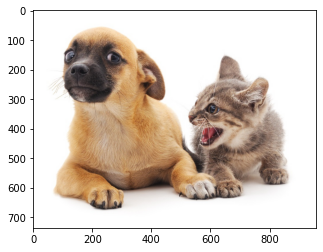

In [ ]:
img = image.imread('/content/drive/MyDrive/Colab Notebooks/Week7/catdog.jpg')
d2l.plt.imshow(img.asnumpy());

4. Create the `X`, which is a transformation of `img` using the following preprocessing steps:

    1. Transpose the dimensions so that the channel dimension comes first (keep the width & height in the same order).
    2. Add an additional dimension to the numpy array.
    3. Normalize the image so its pixel values fall between 0 and 1 (inclusive).

In [ ]:
X = np.expand_dims(img.astype('float32').transpose(2, 0, 1), axis=0) / 255

5. Apply the transposed convolutional layer (`conv_trans`) to the preprocessed image and save the result as `Y`.

In [ ]:
Y = conv_trans(X)

6. Take the single image from the result (at index 0) and transpose it so channels come last. Save it as `out_img`.

In [ ]:
out_img = Y[0].transpose(1, 2, 0)

7. View the new image and compare it to the original image above.

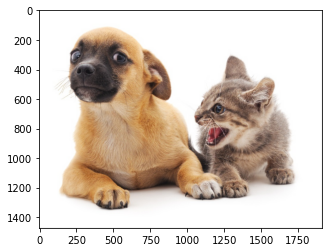

In [ ]:
d2l.plt.imshow(out_img.asnumpy());

8. Compare the shapes of the original and new images.

In [ ]:
print('Input image shape:', img.shape)
print('Output image shape:', out_img.shape)


Input image shape: (736, 957, 3)
Output image shape: (1472, 1914, 3)


As you can see, the transposed convolution layer magnifies both the height and width of the image by a factor of 2. It is worth mentioning that, besides to the difference in coordinate scale, the image magnified by bilinear interpolation and original image printed look the same.

## Part 4: Initialize the final 2 layers of the FCN model

In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation. For a $1\times 1$ convolution layer, we use Xavier for random initialization.

1. Make a bilinear kernal with which to initialize the final transposed convolutional layer. Save it as `W`.

    Note: The number of input and output channels is the number of classes (21) and we want to enlarge the final images by a factor of 32.

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)

2. Initialize the final layer of `net` with `W`.

In [ ]:
net[-1].initialize(init.Constant(W))

3. Initialize the second to last layer with the Xavier initialization.

In [ ]:
net[-2].initialize(init=init.Xavier())

## Part 5: Training and Predicting

#### Read in the Dataset

1. Read in the dataset to get the training and test sets.

    We read the dataset using the `load_data_voc()` function from the `d2l` library. Here, we specify shape of the randomly cropped output image as $320\times 480$, so both the height and width are divisible by 32.

In [ ]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


#### Training

Now we can start training the model. The loss function and accuracy calculation here are not substantially different from those used in image classification. Because we use the channel of the transposed convolution layer to predict pixel categories, the `axis=1` (channel dimension) option is specified in `SoftmaxCrossEntropyLoss`. In addition, the model calculates the accuracy based on whether the prediction category of each pixel is correct.

2. Run the following code to train the model.

loss 0.298, train acc 0.900, test acc 0.811
27.4 examples/sec on [gpu(0)]


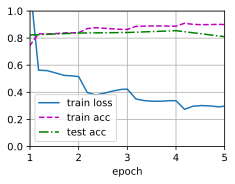

In [ ]:
num_epochs, lr, wd = 5, 0.1, 1e-3
devices = d2l.try_all_gpus()
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(devices)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd})
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

#### Prediction

During predicting, we need to standardize the input image in each channel and transform them into the four-dimensional input format required by the convolutional neural network.


In [ ]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = np.expand_dims(X.transpose(2, 0, 1), axis=0)
    pred = net(X.as_in_ctx(devices[0])).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

To visualize the predicted categories for each pixel, we map the predicted categories back to their labeled colors in the dataset.


In [ ]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, ctx=devices[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

The size and shape of the images in the test dataset vary. Because the model uses a transposed convolution layer with a stride of 32, when the height or width of the input image is not divisible by 32, the height or width of the transposed convolution layer output deviates from the size of the input image. In order to solve this problem, we can crop multiple rectangular areas in the image with heights and widths as integer multiples of 32, and then perform forward computation on the pixels in these areas. When combined, these areas must completely cover the input image. When a pixel is covered by multiple areas, the average of the transposed convolution layer output in the forward computation of the different areas can be used as an input for the softmax operation to predict the category.

For the sake of simplicity, we only read a few large test images and crop an area with a shape of $320\times480$ from the top-left corner of the image. Only this area is used for prediction. For the input image, we print the cropped area first, then print the predicted result, and finally print the labeled category.

3. Run the following code to make predictions and show the results.

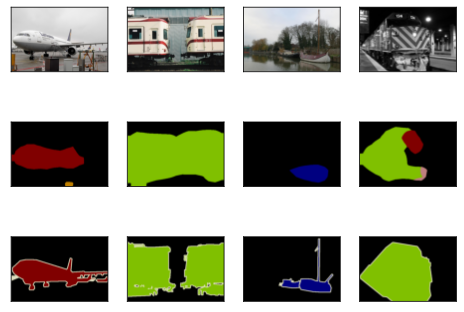

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## Summary

* The fully convolutional network first uses the convolutional neural network to extract image features, then transforms the number of channels into the number of categories through the $1\times 1$ convolution layer, and finally transforms the height and width of the feature map to the size of the input image by using the transposed convolution layer to output the category of each pixel.
* In a fully convolutional network, we initialize the transposed convolution layer for upsampled bilinear interpolation.